# Fall 2022 Data Science Intern Challenge


In [270]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import skew
from bubble_plot.bubble_plot import bubble_plot

## Question 1

### Q1.a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

In [271]:
# load the data
df_shopify_sneakers =pd.read_csv("raw_data.csv",index_col="order_id")
print('The DataFrame dimension is {}'.format(df_shopify_sneakers.shape))
df_shopify_sneakers.head()

The DataFrame dimension is (5000, 6)


,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
1,53,746,224,2,cash,2017-03-13 12:36:56
2,92,925,90,1,cash,2017-03-03 17:38:52
3,44,861,144,1,cash,2017-03-14 4:23:56
4,18,935,156,1,credit_card,2017-03-26 12:43:37
5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [272]:
df_shopify_sneakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   shop_id         5000 non-null   int64 
 1   user_id         5000 non-null   int64 
 2   order_amount    5000 non-null   int64 
 3   total_items     5000 non-null   int64 
 4   payment_method  5000 non-null   object
 5   created_at      5000 non-null   object
dtypes: int64(4), object(2)
memory usage: 273.4+ KB


No missing value is found!

In [273]:
# investigation of order_amount column
percentile = [0.9,0.95,0.98,0.985,0.99,0.995,0.999]
print(df_shopify_sneakers['order_amount'].describe(percentiles = percentile))
print(f"The Skewness of data in order amount is {skew(df_shopify_sneakers['order_amount'].tolist())}")

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
50%         284.000000
90%         531.000000
95%         640.000000
98%         800.080000
98.5%       948.180000
99%       25725.000000
99.5%     77175.000000
99.9%    704000.000000
max      704000.000000
Name: order_amount, dtype: float64
The Skewness of data in order amount is 16.670030505539835


<font size="4.5">The AOV calculated in the first place:</font>

In [274]:
print(f"Current non-valid AOV calculated is ${round(df_shopify_sneakers['order_amount'].mean(), 2)}")

Current non-valid AOV calculated is $3145.13


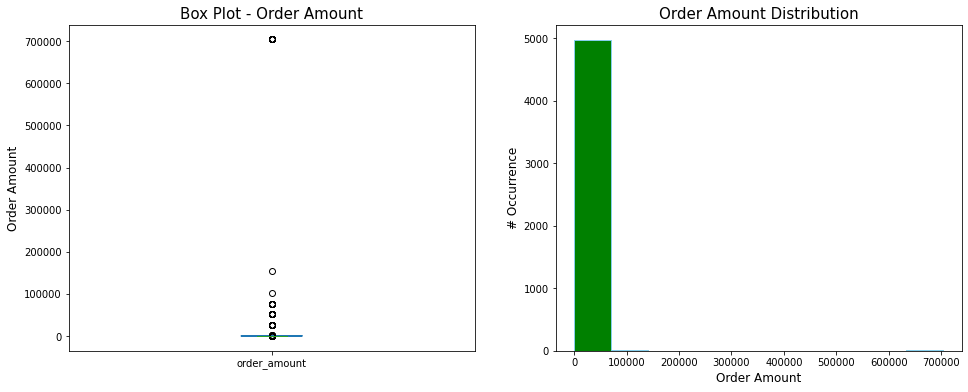

In [275]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df_shopify_sneakers['order_amount'].plot.hist(ax=ax[1], color = "green", ec="skyblue")
ax[1].set_xlabel("Order Amount", size=12)
ax[1].set_ylabel("# Occurrence", size=12)
ax[1].set_title("Order Amount Distribution", size=15)

df_shopify_sneakers['order_amount'].plot.box(ax=ax[0], notch ='True')
ax[0].set_ylabel("Order Amount", size=12)
ax[0].set_title("Box Plot - Order Amount", size=15)
plt.show()

In [276]:
fig = px.scatter(df_shopify_sneakers, x="order_amount", y="total_items", log_y=True , log_x=True,size_max=60)
fig.update_layout(
    title={
        'text': "Log-Log plot of total item vs order amount",
        'xanchor': 'center',
        'yanchor': 'top',
        'y':0.95,
        'x':0.5,})
fig.show()

In [277]:
#Creating amount_per_item
df_shopify_sneakers["amount_per_item"] = df_shopify_sneakers["order_amount"]/df_shopify_sneakers["total_items"]
df_shopify_sneakers["amount_per_item"].describe()

count     5000.000000
mean       387.742800
std       2441.963725
min         90.000000
25%        133.000000
50%        153.000000
75%        169.000000
max      25725.000000
Name: amount_per_item, dtype: float64

The reason of having high AOV is the existance of **outliers** as depicted in the box plot and order amount distribution chart

As shown there are order with amount of ~700K and size of 2000 (bulk orders) which unbalanced the dataset and affected the AOV.

**Let's detect the outliers and remove them systematically**

In [278]:
c1 = df_shopify_sneakers["total_items"]!=2000
c2 = df_shopify_sneakers["amount_per_item"]<df_shopify_sneakers["amount_per_item"].quantile(0.99)
df_shopify_sneakers_no_outlier = df_shopify_sneakers[c1 & c2]

Stores 42 and 78 have anomalous order amount

In [279]:
print(f"The updated AOV calculated is ${round(df_shopify_sneakers_no_outlier['order_amount'].mean(), 2)}")

The updated AOV calculated is $300.16


In [280]:
# Statistics of data with no outlier
print(df_shopify_sneakers_no_outlier['order_amount'].describe(percentiles = percentile))

count    4903.000000
mean      300.155823
std       155.941112
min        90.000000
50%       284.000000
90%       519.000000
95%       588.000000
98%       709.920000
98.5%     724.470000
99%       771.860000
99.5%     815.000000
99.9%     960.000000
max      1086.000000
Name: order_amount, dtype: float64


As we can see here after removing the outliers we have AOV of $300.16 which is a reasonable amount. 

### Q1.b. What metric would I report for this dataset?

The median of data would be a wise choice since it indicates value at the center of the ordered dataset and it's completely free from influence of outliers. Usage of medians is well-known in summarizing data with long tails.

### Q1.c. What is its value?

In [281]:
print(df_shopify_sneakers_no_outlier['order_amount'].median())

284.0


## Question 2

### Q2.a. How many orders were shipped by Speedy Express in total?

``` mysql
SELECT count(*) FROM Orders where ShipperID in 
(SELECT Shippers.ShipperID FROM Shippers Where Shippers.ShipperName = 'Speedy Express')
```

Result: 54

### Q2.b. What is the last name of the employee with the most orders?

``` mysql
SELECT E.LastName
FROM Employees E JOIN Orders O ON E.EmployeeID = O.EmployeeID
GROUP BY E.LastName
ORDER BY COUNT(*) DESC
LIMIT 1;
```

Result: Peacock

### Q2.c. What product was ordered the most by customers in Germany?

``` mysql
SELECT P.ProductName 
FROM Customers Cu, Orders O, Products P, OrderDetails OD
WHERE Cu.Country = "Germany" AND Cu.CustomerID = O.CustomerID AND OD.OrderID = O.OrderID AND OD.ProductID = P.ProductID
GROUP BY P.ProductID
ORDER BY SUM(Quantity) DESC
```

Result: Boston Crab Meat